# Analyzing iMessage Conversations with GF

## Load chat data in sqlite

##### Load chat data from ~/username/Library/Messages/chat.db into sqlite to use the native macOS sqlite to open up the chat.db type: 

`sqlite3 /Users/username/Library/Messages/chat.db` 



#### Look into the tables with: 

`.tables`

Three sections: 
* extracting the data
* transforming (cleaning) the data
* getting insights into data 
** Messages I sent versus bridget

In [157]:
import sqlite3
import pandas as pd
import datetime
import emoji
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('Set2')
%matplotlib inline

In [158]:
# connect to sqlite chat database in user directory
sqlite_db = sqlite3.connect('/Users/adamstueckrath/Library/Messages/chat.db')

In [159]:
# get a “cursor” to execute sql commands
sql_command = sqlite_db.cursor()

In [160]:
# sql query -> need to expand and give description 
query = '''
        SELECT * FROM chat
        INNER JOIN handle
            ON chat.chat_identifier = handle.id
        INNER JOIN chat_handle_join
            ON  handle.ROWID = chat_handle_join.handle_id
        INNER JOIN message
            ON message.handle_id = chat_handle_join.handle_id
        WHERE (chat_identifier LIKE '%8385'
            OR chat_identifier LIKE '%622%')
            AND length(message.text) > 0
        '''

# execute sql query in sqlite3 
table = sql_command.execute(query)

# get list of column names. example: ['ROWID', 'account', 'account_guid']
# table.description is description of columns
column_names = list(map(lambda x: x[0], table.description))

# load sql table into pandas dataframe and pass in the column names
chat_df = pd.DataFrame(table.fetchall(), columns=column_names)

In [161]:
# List all of the tables in chat.db 

# Investigate data

#***MAKE NOTE OF STORED READ RECEIPTS "is_read"*** -> user expected behavior?? Maybe, maybe not?



In [162]:
# display iMessage chat dataframe head() 
chat_df.tail(2)

,ROWID,guid,style,state,account_id,...,ck_record_change_tag,destination_caller_id,sr_ck_sync_state,sr_ck_record_id,sr_ck_record_change_tag
115156,3,iMessage;-;+12246228385,45,3,3AF46D92-D26E-4FE7-AAE0-12EB5480563D,...,,+15154180987,0,,
115157,3,iMessage;-;+12246228385,45,3,3AF46D92-D26E-4FE7-AAE0-12EB5480563D,...,,+15154180987,0,,


## Transform Data

In [163]:
# select columns from chat dataframe
column_list = ['id','is_from_me','text','cache_has_attachments','date']
chat_df = chat_df[column_list]

# show the last 5 rows with selected columns
chat_df.tail()

,id,is_from_me,text,cache_has_attachments,date
115153,+12246228385,0,Woo!!!,0,545516745077822464
115154,+12246228385,0,You’ll have groceries and dry cleaning so soon,0,545516756280858048
115155,+12246228385,0,And sex! Lots of sex!,0,545516764165205696
115156,+12246228385,1,Omg I can’t wait,0,545516776625032448
115157,+12246228385,1,Lol its fucking cold to get dry cleaning,0,545516784110073344


In [164]:
# house cleaning - drop duplicate columns from dataframe
chat_df = chat_df.loc[:,~chat_df.columns.duplicated()]

# rename columns 
chat_df.rename(columns={'id':'phone_number','is_from_me':'is_sent', 
                        'text':'message','cache_has_attachments':'is_picture', 
                        'date':'message_date'}, inplace=True)

# show the last 5 rows with selected columns
chat_df.tail()

,phone_number,is_sent,message,is_picture,message_date
115153,+12246228385,0,Woo!!!,0,545516745077822464
115154,+12246228385,0,You’ll have groceries and dry cleaning so soon,0,545516756280858048
115155,+12246228385,0,And sex! Lots of sex!,0,545516764165205696
115156,+12246228385,1,Omg I can’t wait,0,545516776625032448
115157,+12246228385,1,Lol its fucking cold to get dry cleaning,0,545516784110073344


In [165]:
# add column is_received column
# it is the opposite of is_sent. exmaple: is_sent = 1, is_received = 0
# axis=1 defines that function is to be applied on each row
chat_df['is_received'] = chat_df.apply(lambda row: int(not bool(row.is_sent)), axis=1)

In [166]:
# transform phone_number df.apply (lambda row: label_race (row),axis=1)
def clean_phone_numb(number):
    if bool(number):
        return '515-418-0987'
    return '224-622-8385'

chat_df['phone_number'] = chat_df.apply(lambda row: clean_phone_numb(row.is_sent), axis=1)


In [167]:
# transform message_date column into datetime.datetime object 
# convert numpy.int64 into pandas time ojbect 
# convert time object into datetime.datetime
chat_df['message_date'] = pd.to_datetime(chat_df['message_date'], unit='ns') 
chat_df['message_date'] = chat_df.apply(lambda row: row.message_date.to_pydatetime(warn=False),axis=1)
chat_df['message_date'] = chat_df.apply(lambda row: row.message_date + pd.DateOffset(years=30),axis=1)

chat_df.tail()


,phone_number,is_sent,message,is_picture,message_date,is_received
115153,224-622-8385,0,Woo!!!,0,2017-04-15 20:25:45.077822,1
115154,224-622-8385,0,You’ll have groceries and dry cleaning so soon,0,2017-04-15 20:25:56.280858,1
115155,224-622-8385,0,And sex! Lots of sex!,0,2017-04-15 20:26:04.165205,1
115156,515-418-0987,1,Omg I can’t wait,0,2017-04-15 20:26:16.625032,0
115157,515-418-0987,1,Lol its fucking cold to get dry cleaning,0,2017-04-15 20:26:24.110073,0


In [168]:
# add name column 
def add_name_col(phone_number):
    if phone_number == '515-418-0987':
        return 'Adam'
    return 'Bridget'

chat_df['name'] = chat_df.apply(lambda row: add_name_col(row.phone_number), axis=1)

## Data Visualization

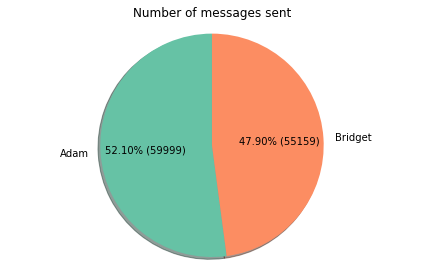

In [169]:
# pie chart for the % of messages between each other
labels = ['Adam', 'Bridget']
values = [chat_df['is_sent'].value_counts()[1], 
         chat_df['is_received'].value_counts()[1]]
fig1, ax1 = plt.subplots()

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct

ax1.set_title('Number of messages sent')
ax1.pie(values, labels=labels, autopct=make_autopct(values), shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.show()

In [170]:
# get counts of every word using .lower() 
#chat_df['message'] = chat_df['message'].str.lower()
test = chat_df.message.str.lower().str.split(expand=True).stack().value_counts()
print(test[:5])

you    20133
i      14822
to     12826
the     8799
bb      7904
dtype: int64


In [171]:
# here for decoding/encoding issues
#def changeencode(data, cols):
#    for col in cols:
#        data[col] = data[col].str.decode('iso-8859-1').str.encode('utf-8')
#    return data 

# for the emojis 

def extract_emojis(str):
  return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)